# Обработка изображений

Компьютерное зрение - большая отрасль компьютерной науки, цель которой научить машины распознавать изображения.

Разпознавать - буквально извлекать знания из изображения.

В наше время широкое применение в безопасности - распознавание лиц и отпечатков пальцев, в промышленности - сортировка объектов на конвеерных линиях и пр.

Пример применения в ветеринарии - определение по отпечаткам лап давления в пятке для выявления травм.

![](Kgt4H.png)

Рассмотрим более традиционное применение в биологии - подсчет колоний в чашке петри.

![](a38f4b1a4ca7.jpg)


Современный алгоритм для решения этой задачи приведен в работе 
[OpenCFU, a New Free and Open-Source Software to Count Cell Colonies and Other Circular Objects](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0054072)

Шаги алгоритма вполне логичны: выделить фрагменты нормализованного изображения по порогу и выполнить дополнительные проверки.

![](http://journals.plos.org/plosone/article/figure/image?size=medium&id=info:doi/10.1371/journal.pone.0054072.g001)


Рассмотрим некоторые шаги для понимания принципов работы с изображениями.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загрузка изображения

Чтобы компьютер "видел" и считал, нужно получить цифровое изображение агарового слоя, например с помощью такой установки.

![](http://journals.plos.org/plosone/article/figure/image?size=inline&id=info:doi/10.1371/journal.pone.0033695.g001)

(c) 2012 http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0033695

Мы загрузим примеры изображений со страницы http://opencfu.sourceforge.net/samples.php

(Кому интересно как скачивать из Интернета - раскомментируйте нужные строки)

In [2]:
# import zipfile
# import os
# import requests
# from io import BytesIO as StringIO

In [3]:
# скачаем архив
# u='http://downloads.sourceforge.net/project/opencfu/samples/plosPicHQ.zip?r=http%3A%2F%2Fopencfu.sourceforge.net%2Fsamples.php&ts=1450794551&use_mirror=netcologne'
# r=requests.get(u)
# r

In [4]:
# len(r.content)

Размер архива около 5Мб. Прочитаем и распакуем архив в текущей папке.

In [5]:
# z=zipfile.ZipFile(StringIO(r.content))
# z.namelist()

In [6]:
# z.extractall()
# uu=z.namelist()

Чтобы код работал дальше можно распаковать прилагаемый архив с картинками в текущую рабочую папку, т.е. чтобы в ней была папка `plosPicHQ` с фотографиями.

Загрузим первое из скачанных изображений

In [7]:
# u1=uu[1]
u1='plosPicHQ/q120404-01.jpg'  # задаем путь к файлу с картинкой
I=imread(u1)
I.shape

(1536, 1538, 3)

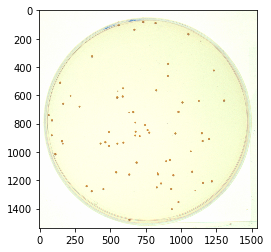

In [8]:
imshow(I);

## Анализ изображения

Как утверждают авторы - точки в чашке - это золотистый стафилококк [Staphylococcus aureus](https://ru.wikipedia.org/wiki/%D0%97%D0%BE%D0%BB%D0%BE%D1%82%D0%B8%D1%81%D1%82%D1%8B%D0%B9_%D1%81%D1%82%D0%B0%D1%84%D0%B8%D0%BB%D0%BE%D0%BA%D0%BE%D0%BA%D0%BA)

Изображение центрировано, и можно "обрезать" края чашки по координатам. Для надежности в реальном приложении нужно разработать специальный детектор края чашки. В крайнем случае, если стеклянный край светлее, чем колонии, то можно считать точки и за пределами чашки - ошибки не будет - ведь их там нет.

Возьмем для простоты прямоугольный фрагмент изображения.

In [9]:
F=I[800:1200, 810:1210]
F.shape

(400, 400, 3)

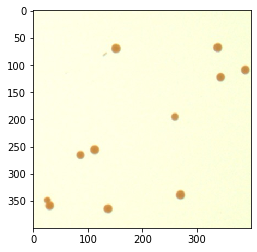

In [10]:
imshow(F);

Рассмотрим три разных канала (RGB)

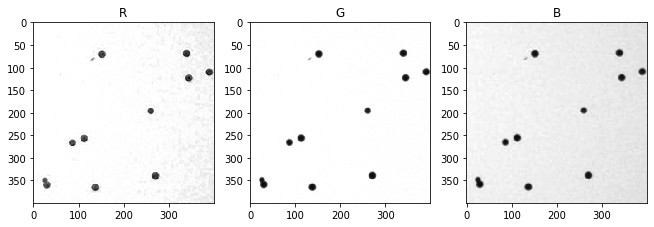

In [11]:
RGB='RGB'
figsize(11,4)
for i in range(F.shape[2]):
    subplot(1,F.shape[2], i+1)
    imshow(F[:,:,i], cmap='gray'); title(RGB[i])

Самый чистый и четкий - второй канал (зеленый). Будем использовать его.

Инвертируем его, чтобы нужные значения были выше фона.  Если колонии белые на агаре с кровью, то, соответственно, инвертировать не нужно.

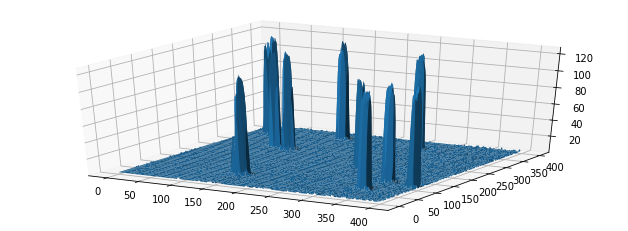

In [12]:
Z=1-F[:,:,1]


#отобразим значения в матрице Z в виде поверхности
from mpl_toolkits.mplot3d import Axes3D

fig = figure()
ax = fig.add_subplot(111, projection='3d')
X,Y = meshgrid(arange(Z.shape[1]), arange(Z.shape[0]))
ax.plot_surface(X,Y,Z);

В цифровом виде участки где выросли бактерии имеют более высокие значения, чем фон. Чтобы найти области, занятые бактериями, достаточно задать пороговое значение.

Для отображения границ одинаковой высоты удобно использовать контур.

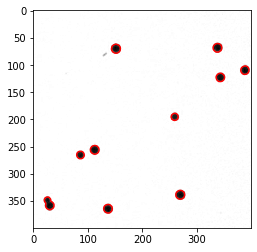

In [13]:
imshow(Z, cmap='gray_r');
coco=contour(Z, [Z.max()/2], colors='r')  # красная линия

In [14]:
n=len(coco.allsegs[0])
n

10

Итак, найдено 10 сегментов контурной линии. Т.е. ответ готов. Можно усовершенствовать алгоритм для обнаружения некруглых объектов (как в левом нижнем углу фрагмента).

Для этого можно перебрать все найденные объекты и проверить их свойства (размер, форму).

In [15]:
n_dubli=0
for co in (coco.allsegs[0]):
    ss=co.max(0)-co.min(0)
    r = ss[0]/ss[1]
    
    # наивная проверка на круглость по отношению ширины и высоты сегмента
    if (r < 0.8) or (r > 1.2):
        vertex = co.min(0) + ss/2
        print('Подозрительно бесформенная колония размером {:.0f}x{:.0f} в ({:.0f},{:.0f})'.format(ss[0],ss[1], vertex[0], vertex[1]))
        
        # если не круглая - значит прибавляем еще одну колонию
        n_dubli+=1
    
n + n_dubli

Подозрительно бесформенная колония размером 18x23 в (29,355)


11

## Продвинутый анализ изображений

Мы рассмотрели простой случай, где колонии достаточно обособлены. В других случаях важно считать не количество, а площадь, занимаемую колониями. Если объекты разных типов, то нужно "научить" программу различать эти типы и считать их отдельно. 
[Примеры интерфейсов программ для полуавтоматического распознования разных клеток](http://ilastik.org/gallery.html).

Если много шума то нужно предварительно подготовить изображение, чтобы не выявлять мелкие частицы. 
Эти и другие процедуры берут на входе двухмерный массив и возвращают также двухмерный массив - в результате можно построить цепочку обработок.

Чтобы получить номера сегментов в виде изображения используем специальную библиотеку для работы с изображениями. Сначала сделаем сглаживание, затем каждой колонии зададим свой цвет, чтобы отличать их друг от друга и от фона.

In [16]:
import skimage.color
import skimage.filters
import skimage.measure

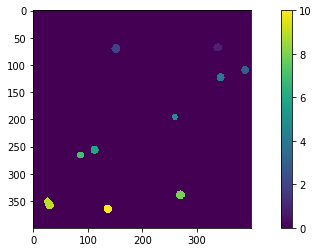

In [17]:
# сглаживаем двухмерным фильтром
Zf = skimage.filters.gaussian(Z, 4)

# размечаем на сегменты превышающие порог
porog = Zf.max()/2  # зададим порог вполовину от высоты "столбиков"
labeled = skimage.measure.label(Zf > porog)
imshow(labeled); colorbar();

Есть способ представить контуры в виде изображения.

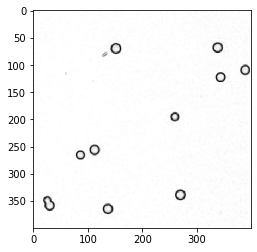

In [18]:
sob = skimage.filters.prewitt(Z)
imshow(sob, cmap='gray_r');

Если разметить отдельные сегменты уже на этом изображении, то получим разноцветные кольца.

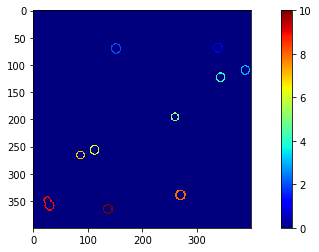

In [19]:
labeled = skimage.measure.label(sob > sob.max()*0.6)
imshow(labeled, cmap=cm.jet); colorbar();

**Вывод**. Лучший алгоритм обработки изображений - специально предназначенный для ваших данных.

Для начала следует попробовать готовые решения (особенно если они бесплатны).

Затем пробовать применить частично готовое - частично свое, например, анализировать предварительно подготовленные изображения.

Впоследствие можно сделать свое решение, в виде компиляции известных методов, но подогнанных именно к вашим задачам.


**Пример сравнения разных методов сегментации изображения из научной статьи**

![](watershed.jpg)




# Самостоятельная работа

Проверьте работу приведенного алгоритма на других фрагментах этого изображения, других изображениях.

Сделайте вывод о возможных путях усовершенствования алгоритма при работе с выбранными вами образцами.
